# Artificial neural network

In [1]:
#imports
from preprocessing.neural_network_preprocessing import get_number_of_numerical_features, NeuralNetworkPreprocessor, CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS
from visualization.neural_network_plots import plot_multiple_loss_curves, plot_multiple_accuracy_curves, plot_multiple_f_scores

from sklearn.metrics import fbeta_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
use_mps = True
use_cuda = False

device = torch.device("cpu")

if torch.has_mps and use_mps:
    device = torch.device("mps")
    print("Torch mps activated")

if torch.has_cuda and use_cuda:
    device = torch.device("cuda")
    print("Torch cuda activated")

Torch mps activated


Looking at the dataset it becomes clear that it is imbalanced

In [4]:
preprocessor = NeuralNetworkPreprocessor()
data_train, data_validation, data_test, target_train, target_validation, target_test = preprocessor.get_preprocessed_dataset_for_neural_network()
target_validation.value_counts()

No   Yes
1.0  0.0    49095
0.0  1.0     7199
dtype: int64

Constants

In [5]:
batch_size = 128
output_size = target_train.shape[1]
embedding_sizes = preprocessor.get_embedding_sizes()
embedding_input_size = sum((nf for ni, nf in embedding_sizes))
numerical_input_size = get_number_of_numerical_features()
input_size = embedding_input_size + numerical_input_size
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")
print(f"Embedding sizes: {embedding_sizes}")

Input size: 50
Output size: 2
Embedding sizes: [(6, 3), (2, 1), (3, 2), (6, 3), (4, 2), (3, 2), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (8, 4), (3, 2), (13, 7), (5, 3), (4, 2), (2, 1), (4, 2), (2, 1), (2, 1), (4, 2), (2, 1)]


Custom torch dataset to separate categorical and numerical values

In [6]:
class CustomBrfssDataset(data_utils.Dataset):
    def __init__(self, dataset_complete, dataset_target):
        self.data_categorical = dataset_complete[CATEGORICAL_COLUMNS]
        self.data_categorical = torch.tensor(np.array(self.data_categorical)).int()

        self.data_numerical = dataset_complete[NUMERICAL_COLUMNS]
        self.data_numerical = torch.tensor(np.array(self.data_numerical)).float()

        self.target = torch.tensor(np.array(dataset_target)).float()

    def __len__(self):
            return len(self.data_categorical)

    def __getitem__(self, idx):
            return self.data_categorical[idx], self.data_numerical[idx], self.target[idx]

Define artificial net

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])

        self.fc1 = nn.Linear(input_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.do2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(5, output_size)

    def forward(self, input_categorical, input_numerical):
        embedding_layers = []
        for index,e in enumerate(self.embeddings):
            embedding_layers.append(e(input_categorical[:,index]))
        x_categorical = torch.cat(embedding_layers, 1)

        x = torch.cat([x_categorical, input_numerical], 1)

        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=False)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=False)
        x = self.do2(x)
        x = self.fc3(x)
        x = F.softmax(x)
        return x

Helper functions for evaluation

In [8]:
def get_accuracy(model: Net, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs_categorical, inputs_numerical, labels = data
            inputs_categorical = inputs_categorical.to(device)
            inputs_numerical = inputs_numerical.to(device)
            labels = labels.to(device)

            outputs = model(inputs_categorical, inputs_numerical)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

def get_loss(model: Net, criterion, data_loader):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(data_loader, 0):

        inputs_categorical, inputs_numerical, labels = data
        inputs_categorical = inputs_categorical.to(device)
        inputs_numerical = inputs_numerical.to(device)
        labels = labels.to(device)

        outputs = model(inputs_categorical, inputs_numerical)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        pass

    return running_loss/len(data_loader)

def get_f_score(model: Net, data_loader):
    running_predictions = []
    running_labels = []

    model.eval()
    for i, data in enumerate(data_loader, 0):

        inputs_categorical, inputs_numerical, labels = data
        inputs_categorical = inputs_categorical.to(device)
        inputs_numerical = inputs_numerical.to(device)
        labels = labels.to(device)

        outputs = model(inputs_categorical, inputs_numerical)
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels.data, 1)
        running_predictions.extend(predicted.detach().cpu().numpy().ravel())
        running_labels.extend(labels.detach().cpu().numpy().ravel())
        pass

    f_score = fbeta_score(y_true=running_labels, y_pred=running_predictions, beta=2, pos_label=1, average="binary")
    precision = precision_score(y_true=running_labels, y_pred=running_predictions)
    recall = recall_score(y_true=running_labels, y_pred=running_predictions)

    return f_score, precision, recall

Training loop

In [9]:
def train_network(model: Net, criterion, optimizer, data_train_loader, data_validation_loader, n_epochs=5):
    loss_values = []
    accuracy_values = []
    loss_values_validation = []
    accuracy_values_validation = []
    f_scores = []
    f_scores_validation = []

    for epoch in range(n_epochs):

        running_loss = 0.0

        model.train()
        for i, data in enumerate(data_train_loader, 0):

            inputs_categorical, inputs_numerical, labels = data
            inputs_categorical = inputs_categorical.to(device)
            inputs_numerical = inputs_numerical.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs_categorical,inputs_numerical)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 batches
                print(f'[{epoch + 1}, {(i + 1) * batch_size}] loss: {running_loss / i:.3f}')
            pass

        loss_values.append(running_loss/len(data_train_loader))
        validation_loss = get_loss(model, criterion, data_validation_loader)
        train_accuracy = 100 * get_accuracy(model, data_train_loader)
        validation_accuracy = 100 * get_accuracy(model, data_validation_loader)
        accuracy_values.append(train_accuracy)
        accuracy_values_validation.append(validation_accuracy)
        loss_values_validation.append(validation_loss)

        print(f"Epoch {epoch} loss: {str(running_loss/len(data_train_loader))}")
        print(f"Epoch {epoch} validation loss: {validation_loss}")
        print(f'Train accuracy epoch {epoch}: {train_accuracy} %')
        print(f'Validation accuracy epoch {epoch}: {validation_accuracy} %')

        f_train, p_train, r_train = get_f_score(net, data_train_loader)
        f_validation, p_validation, r_validation = get_f_score(net, data_validation_loader)
        f_scores.append(f_train)
        f_scores_validation.append(f_validation)

        print(f"Train F2-score : {f_train}")
        print(f"Validation F2-score : {f_validation}")
        print(f"Train Precision : {p_train}")
        print(f"Validation Precision : {p_validation}")
        print(f"Train Recall : {r_train}")
        print(f"Validation Recall : {r_validation}")

    print('Finished Training')
    return loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation

### Train model without under or oversampling

In [10]:
data_train, data_validation, data_test, target_train, target_validation, target_test = preprocessor.get_preprocessed_dataset_for_neural_network()

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

# Custom weighted sampling required because otherwise the f2 score can be zero when all samples are from the same class, random sampling is not suitable
class_count_train = [target_train["No"].sum(),target_train["Yes"].sum()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float)
class_weights_train_all = class_weights_train[np.where(target_train.to_numpy()==1)[1]]

class_count_validation = [target_validation["No"].sum(),target_validation["Yes"].sum()]
class_weights_validation = 1./torch.tensor(class_count_validation, dtype=torch.float)
class_weights_validation_all = class_weights_validation[np.where(target_validation.to_numpy()==1)[1]]

weighted_sampler_train = data_utils.WeightedRandomSampler(weights=class_weights_train_all, num_samples=target_train.shape[0], replacement=True)
weighted_sampler_validation = data_utils.WeightedRandomSampler(weights=class_weights_validation_all, num_samples=target_validation.shape[0], replacement=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_train)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, sampler=weighted_sampler_validation)

net = Net()
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=50)

[1, 12800] loss: 0.589
[1, 25600] loss: 0.553
[1, 38400] loss: 0.537
[1, 51200] loss: 0.526
[1, 64000] loss: 0.518
[1, 76800] loss: 0.514
[1, 89600] loss: 0.509
[1, 102400] loss: 0.506
[1, 115200] loss: 0.503
[1, 128000] loss: 0.502
[1, 140800] loss: 0.500
[1, 153600] loss: 0.498
[1, 166400] loss: 0.496
Epoch 0 loss: 0.49572100309711514
Epoch 0 validation loss: 0.4905717060647228
Train accuracy epoch 0: 76.6310204758352 %
Validation accuracy epoch 0: 76.24080719081962 %
Train F2-score : 0.7738300903553156
Validation F2-score : 0.7738187506165185
Train Precision : 0.7575585570975141
Validation Precision : 0.7629385203195554
Train Recall : 0.778007780434705
Validation Recall : 0.7765874699476736
[2, 12800] loss: 0.490
[2, 25600] loss: 0.481
[2, 38400] loss: 0.481
[2, 51200] loss: 0.480
[2, 64000] loss: 0.481
[2, 76800] loss: 0.480
[2, 89600] loss: 0.480
[2, 102400] loss: 0.480
[2, 115200] loss: 0.479
[2, 128000] loss: 0.477
[2, 140800] loss: 0.477
[2, 153600] loss: 0.477
[2, 166400] loss

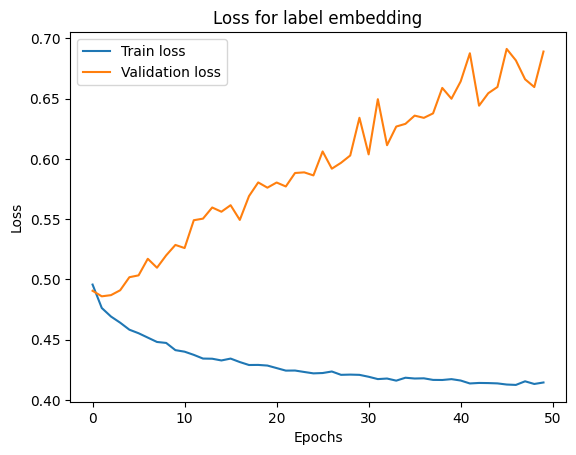

In [11]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for label embedding")

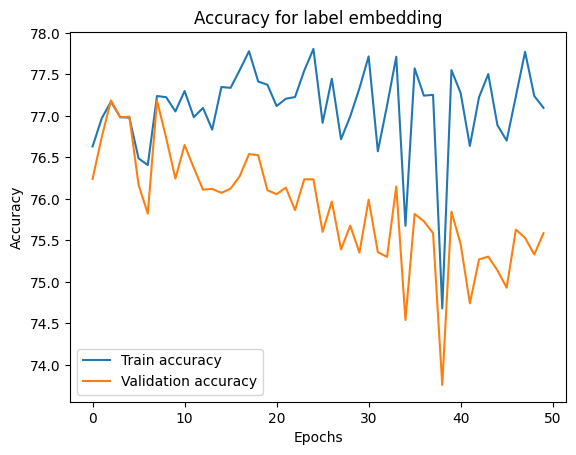

In [12]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for label embedding")

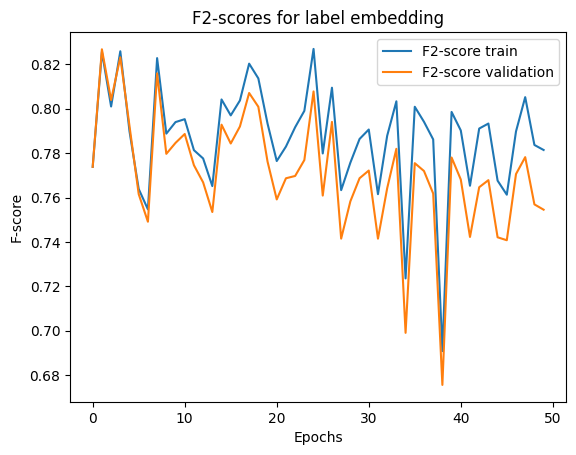

In [13]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for label embedding")

### Train model with undersampling

In [14]:
data_train, data_validation, data_test, target_train, target_validation,  target_test = preprocessor.get_preprocessed_dataset_for_neural_network_undersampled()

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net()
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=100)

[1, 12800] loss: 0.669
[1, 25600] loss: 0.625
[1, 38400] loss: 0.605
Epoch 0 loss: 0.600000522898499
Epoch 0 validation loss: 0.8534695461392403
Train accuracy epoch 0: 65.79386025836922 %
Validation accuracy epoch 0: 42.967278928482614 %
Train F2-score : 0.8580284619956415
Validation F2-score : 0.5128546689756227
Train Precision : 0.5981413281160087
Validation Precision : 0.1787602858100962
Train Recall : 0.9625873963976478
Validation Recall : 0.9626336991248785
[2, 12800] loss: 0.577
[2, 25600] loss: 0.573
[2, 38400] loss: 0.567
Epoch 1 loss: 0.563974034151382
Epoch 1 validation loss: 0.8254743092439392
Train accuracy epoch 1: 66.22679075797564 %
Validation accuracy epoch 1: 43.20176217714143 %
Train F2-score : 0.8611705246467531
Validation F2-score : 0.5148007055719432
Train Precision : 0.6009855055758868
Validation Precision : 0.17963638244497893
Train Recall : 0.9656896791221002
Validation Recall : 0.9648562300319489
[3, 12800] loss: 0.555
[3, 25600] loss: 0.547
[3, 38400] loss: 0

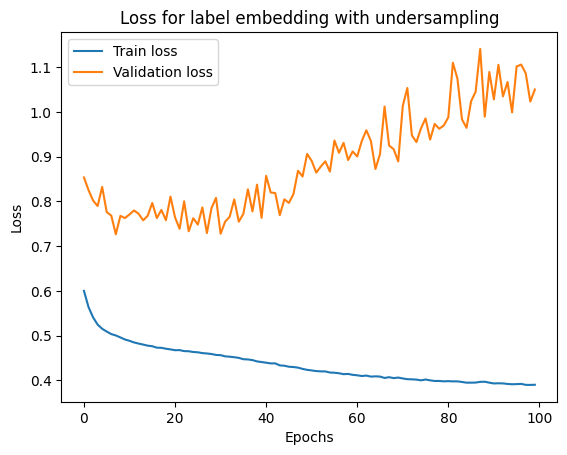

In [15]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for label embedding with undersampling")

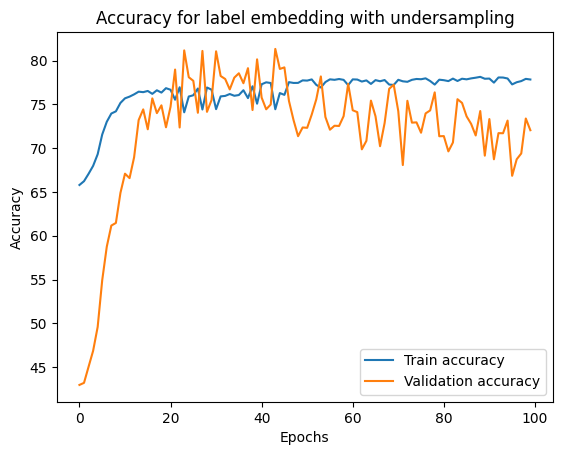

In [16]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for label embedding with undersampling")

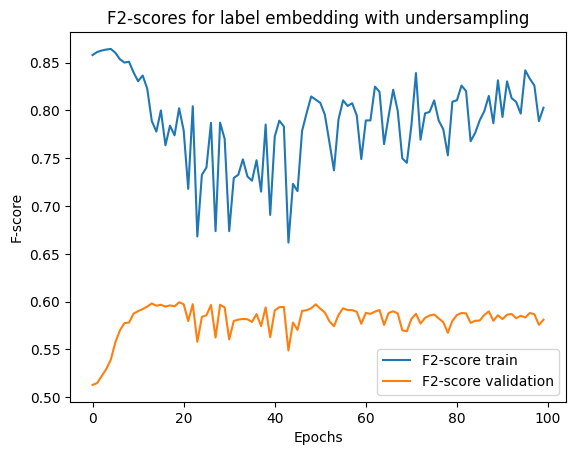

In [17]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for label embedding with undersampling")

In [18]:
data_train, data_validation, data_test, target_train, target_validation,  target_test = preprocessor.get_preprocessed_dataset_for_neural_network_oversampled()

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net()
net.to(device)

criterion_cross_entropy = nn.BCELoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation, f_scores, f_scores_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=25)

[1, 12800] loss: 0.563
[1, 25600] loss: 0.536
[1, 38400] loss: 0.523
[1, 51200] loss: 0.515
[1, 64000] loss: 0.509
[1, 76800] loss: 0.505
[1, 89600] loss: 0.502
[1, 102400] loss: 0.499
[1, 115200] loss: 0.497
[1, 128000] loss: 0.495
[1, 140800] loss: 0.494
[1, 153600] loss: 0.493
[1, 166400] loss: 0.491
[1, 179200] loss: 0.491
[1, 192000] loss: 0.490
[1, 204800] loss: 0.489
[1, 217600] loss: 0.488
[1, 230400] loss: 0.488
[1, 243200] loss: 0.487
[1, 256000] loss: 0.486
[1, 268800] loss: 0.486
[1, 281600] loss: 0.485
[1, 294400] loss: 0.485
Epoch 0 loss: 0.4844506298014643
Epoch 0 validation loss: 0.7832943106239493
Train accuracy epoch 0: 64.04793427708185 %
Validation accuracy epoch 0: 38.012932106441184 %
Train F2-score : 0.8686753891587119
Validation F2-score : 0.5038726820443239
Train Precision : 0.5826631348906708
Validation Precision : 0.16993993707693775
Train Recall : 0.9901890891808399
Validation Recall : 0.9904153354632588
[2, 12800] loss: 0.477
[2, 25600] loss: 0.474
[2, 3840

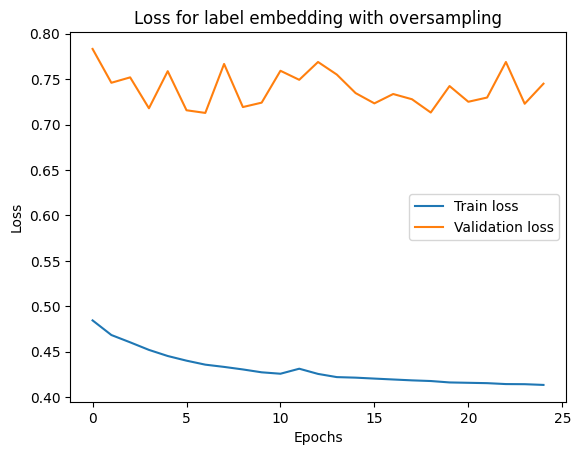

In [19]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for label embedding with oversampling")

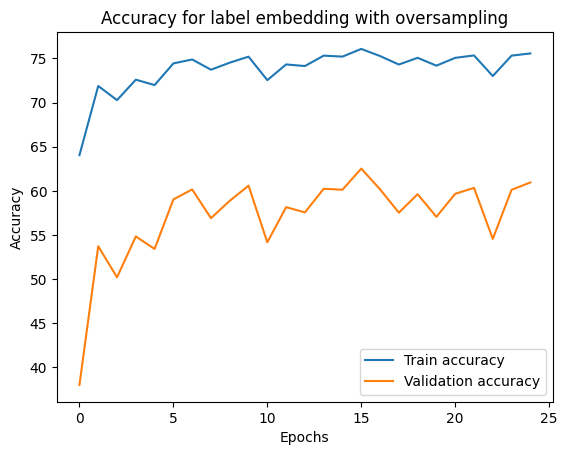

In [20]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for label embedding with oversampling")

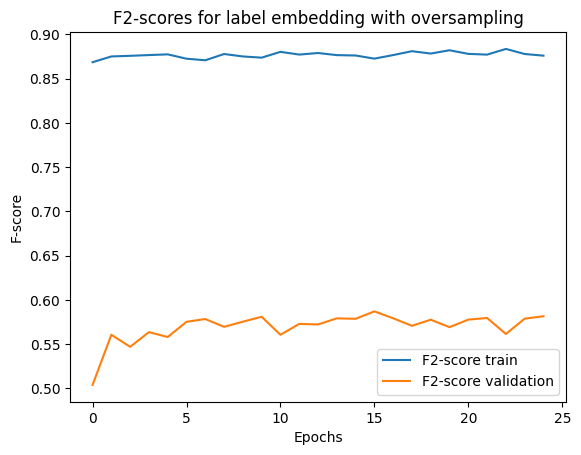

In [21]:
plot_multiple_f_scores([f_scores, f_scores_validation], labels=["F2-score train", "F2-score validation"], title="F2-scores for label embedding with oversampling")